In [31]:
import numpy as np
from sympy import *
import sympy as sym
import math
import matplotlib.pyplot as plt

In [38]:
d0 = 0.67 #-
J3 =  10**7
rho0 = 2350 #kg*m-3 #p0
k0 = 85*10**9 #Pa
mu0 = 22*10**9 #Pa
beta = 2*10**(-5) #K**(-1)
C = 850 #J*kg**(-1)*K**(-1)
sigma_c0 = 10**5 #o0c #?
sigma_d0 = 1.2*10**6 #Pa #o0d
sigma_y0 = 38*10**6 #Pa #o0y
sigma_0 = 300 #K
a = 0.8 #
delq=-30
A1 = 2.5*10**(-4) #-
A2 = 1.5 #-
P1 = 10**(-3)
P2 = 10**(-3)
P3 = 10**(-3)
P4 = 10**(-3)
J=  np.array([[0],[0],[J3]])
kappa_0 = 85*10**9 #Pa #k0
mu_0 = 22*10**9 #Pa #u0
div_q=-30 #derived from q0
theta0 = 300 #K
theta_0 = 300
theta_t0 = 300 #K
dt = 10**(-4) #s
ti = 0
tf = 1 
t = np.arange(0 + dt, tf + dt, dt)
Nt = round(tf/dt)
Eet0= np.array([[kappa_0 + (4/3)*mu_0, kappa_0 - (2/3)*mu_0, kappa_0 - (2/3)*mu_0, 0, 0, 0],\
                [kappa_0 - (2/3)*mu_0, kappa_0 + (4/3)*mu_0, kappa_0 - (2/3)*mu_0, 0, 0, 0],\
                [kappa_0 - (2/3)*mu_0, kappa_0 - (2/3)*mu_0, kappa_0 + (4/3)*mu_0, 0, 0, 0],\
                [0, 0, 0, mu_0, 0, 0],\
                [0, 0, 0, 0, mu_0, 0],\
                [0, 0, 0, 0, 0, mu_0]]) #Eet=EE0
pvec = np.zeros([Nt,1])
thetavec = [theta_0] + [0]*(Nt-1)
sigma_dev = np.zeros((3, 3)) + np.identity(3)
#sigmadevvec = np.zeros([Nt,1])
dvec =[d0] + [0]*(Nt-1)
timevec = np.linspace(0, tf, Nt)
Epsvec = np.zeros([Nt,1])
dthetavec = np.zeros([Nt,1])
sigmavec = np.zeros([3,3])
Epvec = np.zeros([3,3])
Etvec = np.zeros([3,3])

In [33]:
#initializing conditions:
d = d0
theta = theta_t0
sigma_dev = np.zeros((3, 3)) + np.identity(3)
Ep = 0
p_plot = []
sigma_dev_plot = []
d_plot = []
theta_plot = []
Ep_plot = []

In [34]:
for n in t:
    # Specify F and its Jacobian
    B = np.zeros((3, 3))
    B[2, 2] = -0.15 * n
    F = np.identity(3) + B
    Jac = np.linalg.det(F)

    # Specify E
    E = 0.5 * (np.dot(np.transpose(F), F) - np.identity(3))

    # Specify material parameters as a function of d and theta
    Eet = (1 - d) * Eet0 * np.exp(-P1 * (theta - theta0) / theta0)
    sigma_c = (1 - d) * sigma_c0 * np.exp(-P2 * (theta - theta0) / theta0)
    sigma_d = sigma_d0 * np.exp(-P3 * (theta - theta0) / theta0)
    sigma_y = sigma_y0 * np.exp(-P4 * (theta - theta0) / theta0)
    
    # Specify Ep based on plasticity model
    if np.linalg.norm(sigma_dev, ord='fro') > sigma_y:
        lambda_p = A2 * (np.linalg.norm(sigma_dev, ord='fro') / sigma_y - 1)
    else:
        lambda_p = 0
    ep = lambda_p / np.linalg.norm(sigma_dev, ord='fro') * sigma_dev
    Ep_dot = Jac * np.dot(np.dot(np.linalg.inv(F), ep), np.linalg.inv(np.transpose(F)))
    Ep_new = Ep + dt * Ep_dot
    Ep = Ep_new
    
    
    # Specify Etheta and Joule heating
    Etheta = beta * (theta - theta0) * np.identity(3)
    JH = a / sigma_c * Jac * np.sum(J * J)

    #Second piola kirchoff strain
    Ee = E-Ep-Etheta
    Ee61 = np.array([[Ee[0,0]],[Ee[1,1]],[Ee[2,2]],[2*Ee[0,1]],[2*Ee[1,2]],[2*Ee[2,0]]])
    S33= np.array([[Eet[0,0]*Ee[0,0]+Eet[0,1]*Ee[1,1]+Eet[0,2]*Ee[2,2],Eet[3,3]*Ee[0,1],Eet[5,5]*Ee[0,2]],\
                [Eet[3,3]*Ee[0,1],Eet[1,0]*Ee[0,0]+Eet[1,1]*Ee[1,1]+Eet[1,2]*Ee[2,2],Eet[4,4]*Ee[1,2]],\
                [Eet[5,5]*Ee[2,1],Eet[4,4]*Ee[2,1],Eet[2,0]*Ee[0,0]+Eet[2,1]*Ee[1,1]+Eet[2,2]*Ee[2,2]]])
    S61 = np.array([[S33[0,0]],[S33[1,1]],[S33[2,2]],[2*S33[0,1]],[2*S33[1,2]],[2*S33[2,0]]])
    tr_S = np.sum(S33 * np.identity(3))

    # Calculate Cauchy stress and its spherical and deviatoric form
    sigma = (1/Jac)*np.dot(np.dot(F,S33), np.transpose(F)) 
    sigma_dev = sigma - 1/3*(sigma[0,0]+sigma[1,1]+sigma[2,2])*np.identity(3)

    # Hydrostatic pressure
    p = -1/3 * (sigma[0,0]+sigma[1,1]+sigma[2,2])

  
    if abs(p)>sigma_d and d<1:
        d_dot = -A1*(abs(p)/sigma_d - 1)
    elif d<0:
        d = 0
        d_dot = 0
    else:
        d_dot = 1
    d = d+d_dot*dt


    # Estimate temperature
    Num = np.sum(S33 * Ep_dot) + d_dot/(2 * (1 - d)) * np.sum(Ee61 * S61) - div_q + JH
    Den = rho0 * C - beta * tr_S - P1 / (2 * theta0) * np.sum(Ee61 * S61)
    theta_dot = Num / Den
    theta_new = theta + dt * theta_dot
    theta = theta_new

    # Gather data for plotting
    p_plot.append(p)
    sigma_dev_plot.append(np.linalg.norm(sigma_dev, ord=2))
    d_plot.append(d)
    theta_plot.append(theta)
    Ep_plot.append(np.linalg.norm(Ep))




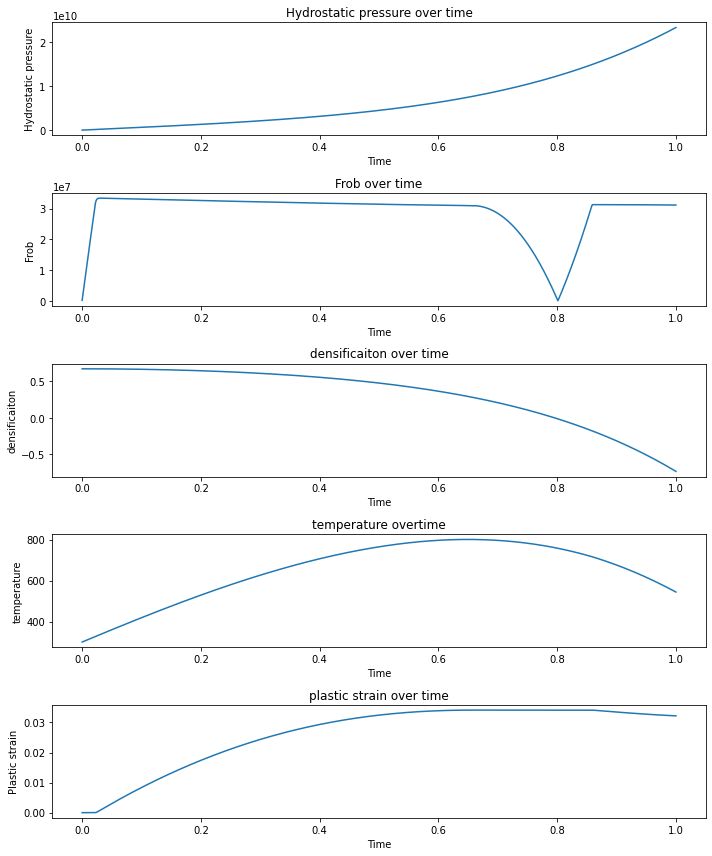

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that p_plot, sigma_dev_plot, d_plot, theta_plot, and Ep_plot are lists of values and t is a list of time values.

# Create a figure with 5 subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

# Plot p_plot as a function of time
axs[0].plot(t, p_plot)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Hydrostatic pressure')
axs[0].set_title('Hydrostatic pressure over time')

# Plot sigma_dev_plot as a function of time
axs[1].plot(t, sigma_dev_plot)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frob')
axs[1].set_title('Frob over time')

# Plot d_plot as a function of time
axs[2].plot(t, d_plot)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('densificaiton')
axs[2].set_title('densificaiton over time')

# Plot theta_plot as a function of time
axs[3].plot(t, theta_plot)
axs[3].set_xlabel('Time')
axs[3].set_ylabel('temperature')
axs[3].set_title('temperature overtime')

# Plot Ep_plot as a function of time
axs[4].plot(t, Ep_plot)
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Plastic strain')
axs[4].set_title('plastic strain over time')

# Adjust the layout and spacing of the subplots
fig.tight_layout()

plt.show()
